In [1]:

import os
import torch
import numpy as np
import scipy.stats
from collections import defaultdict
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

pyro.clear_param_store()
pyro.set_rng_seed(1)


In [2]:

import pandas as pd
import numpy as np

rtdata = pd.read_csv('mcfrt.csv')
rtdata = rtdata.query('chr == "1"')
rtdata


,chr,start,end,gc,mcf7rt,bin_size
0,1,1000000,1500000,0.598330,81.441980,500000
1,1,1500000,2000000,0.539496,79.131013,500000
2,1,2000000,2500000,0.594508,78.557313,500000
3,1,3000000,3500000,0.584570,70.388076,500000
4,1,4000000,4500000,0.482572,48.663092,500000
...,...,...,...,...,...,...
423,1,246000000,246500000,0.404142,47.146415,500000
424,1,246500000,247000000,0.428546,70.978030,500000
425,1,247000000,247500000,0.425162,58.722962,500000
426,1,247500000,248000000,0.400436,30.497224,500000


In [3]:

import matplotlib.pyplot as plt
import seaborn as sns

rtdata['norm_mcf7rt'] = (rtdata['mcf7rt'] - rtdata['mcf7rt'].min()) / (rtdata['mcf7rt'].max() - rtdata['mcf7rt'].min())

sns.lineplot(x='start', y='norm_mcf7rt', data=rtdata)


<AxesSubplot:xlabel='start', ylabel='norm_mcf7rt'>

In [4]:

starts = rtdata['start'].values
rt = rtdata['norm_mcf7rt'].values
num_cells = 170
num_loci = 400

cn = np.ones((rt.shape[0], num_cells)) * 2

starts = starts[:num_loci]
rt = torch.tensor(rt[:num_loci])
cn = torch.tensor(cn[:num_loci, :])


 Trace Shapes:          
  Param Sites:          
          nb_r         1
 Sample Sites:          
        a dist       1 |
         value       1 |
      log_prob       1 |
num_cells dist         |
         value     170 |
      log_prob         |
        t dist     170 |
         value     170 |
      log_prob     170 |
        u dist     170 |
         value     170 |
      log_prob     170 |
 num_loci dist         |
         value     400 |
      log_prob         |
      rep dist 400 170 |
         value 400 170 |
      log_prob 400 170 |
    reads dist 400 170 |
         value 400 170 |
      log_prob 400 170 |


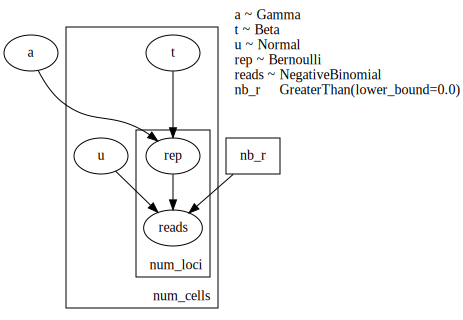

In [5]:

@config_enumerate
def model_S(cn, rt0=None, num_cells=None, data=None):
    assert (num_cells is None) != (data is None)

    if data is not None:
        num_cells = data.shape[1]

    num_loci = cn.shape[0]

    # controls the consistency of replicating on time
    a = pyro.sample('a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))
    
    if rt0 is not None:
        rt = rt0
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('rt', dist.Normal(torch.ones(num_loci)*0.5, 0.1))

    with pyro.plate('num_cells', num_cells):

        # per cell replication time
        t = pyro.sample('t', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

        # per cell reads per copy per bin
        u = pyro.sample('u', dist.Normal(torch.tensor([70.]), torch.tensor([10.])))

        with pyro.plate('num_loci', num_loci):

            # per cell per bin late or early 
            t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * t_diff))

            # binary replicated indicator
            rep = pyro.sample('rep', dist.Bernoulli(p_rep))

            # copy number accounting for replication
            rep_cn = cn * (1. + rep)

            # negative binomial dispersion
            nb_r = pyro.param('nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

            # expected reads per bin per cell
            expected_reads = (u * rep_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=data)

trace = poutine.trace(model_S).get_trace(cn, rt, num_cells=num_cells)
trace.compute_log_prob()
print(trace.format_shapes())
pyro.render_model(model_S, model_args=(cn, rt, num_cells), 
                  render_distributions=True, render_params=True)

 Trace Shapes:          
  Param Sites:          
          nb_r         1
 Sample Sites:          
        a dist       1 |
         value       1 |
      log_prob       1 |
num_loci0 dist         |
         value     400 |
      log_prob         |
       rt dist     400 |
         value     400 |
      log_prob     400 |
num_cells dist         |
         value     170 |
      log_prob         |
        t dist     170 |
         value     170 |
      log_prob     170 |
        u dist     170 |
         value     170 |
      log_prob     170 |
 num_loci dist         |
         value     400 |
      log_prob         |
      rep dist 400 170 |
         value 400 170 |
      log_prob 400 170 |
    reads dist 400 170 |
         value 400 170 |
      log_prob 400 170 |


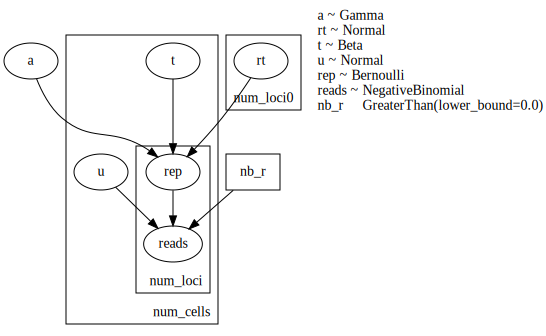

In [6]:
trace = poutine.trace(model_S).get_trace(cn, num_cells=num_cells)
trace.compute_log_prob()
print(trace.format_shapes())
pyro.render_model(model_S, model_args=(cn, None, num_cells), 
                  render_distributions=True, render_params=True)

In [7]:

# Simulate conditioned on a, get reads, replication timing etc

pyro.clear_param_store()

conditioned_model = poutine.condition(
    model_S,
    data={
        'a': torch.tensor([10.]),
    })

model_trace = pyro.poutine.trace(conditioned_model)

samples = model_trace.get_trace(cn, rt, num_cells=num_cells)

t = samples.nodes['t']['value']
a = samples.nodes['a']['value']
u = samples.nodes['u']['value']
nb_r = samples.nodes['nb_r']['value']

t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)
p_rep = 1 / (1 + torch.exp(-a * t_diff))

rep = samples.nodes['rep']['value']

rep_cn = cn * (1. + rep)

reads = samples.nodes['reads']['value']

# a, t, rt, p_rep, t_diff, rep, rep_cn, reads


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


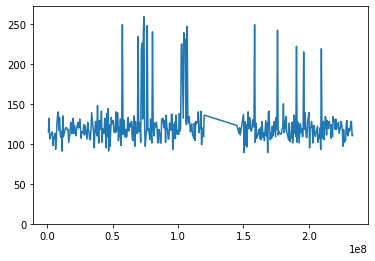

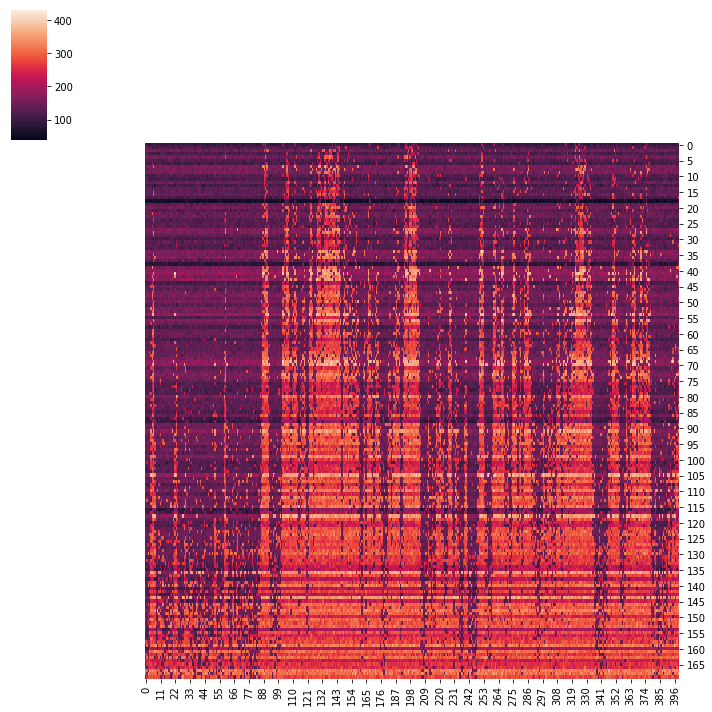

In [8]:

# Visualize one cell and matrix

sns.lineplot(starts, reads[:, 1])
plt.ylim((0, 1.05 * reads[:, 1].max()))

sns.clustermap(reads.numpy().astype(float).T[np.argsort(t), :], col_cluster=False, row_cluster=False)


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


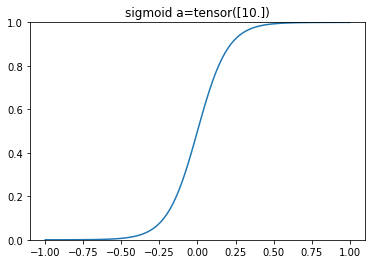

In [9]:

def plot_sigmoid(a):
    x = np.linspace(-1, 1, 101)
    y = 1 / (1 + np.exp(-a * x))

    sns.lineplot(x, y)
    plt.title(f'sigmoid a={a}')
    plt.ylim((0, 1))

plot_sigmoid(samples.nodes['a']['value'].detach())


In [10]:

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=2)


In [11]:

conditioned_model = poutine.condition(
    model_S,
    data={
# Uncomment to condition on various hidden variables
#         'a': torch.tensor([10.]),
#         'rep': rep,
#         't': t,
#         'nb_r': torch.tensor([10000.0]),
    })

guide = AutoDelta(
    poutine.block(conditioned_model, expose=['a', 'u', 't', 'nb_r', 'rt'], hide=['rep']),
)
svi = SVI(conditioned_model, guide, optim, loss=elbo)


In [12]:
cn = cn.type(torch.float32)
reads = reads.type(torch.float32)

In [13]:

# Calculate initial loss

pyro.clear_param_store()

elbo.loss(conditioned_model, guide, cn, data=reads)


471813.59375

In [14]:

# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi.step(cn, data=reads)
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')



...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

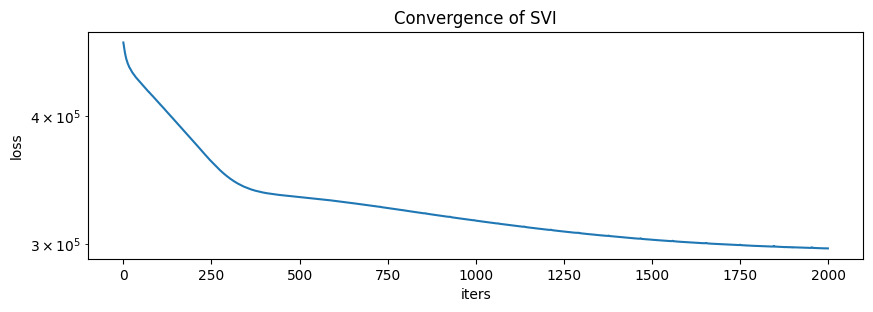

In [15]:

plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]], dtype=float32)

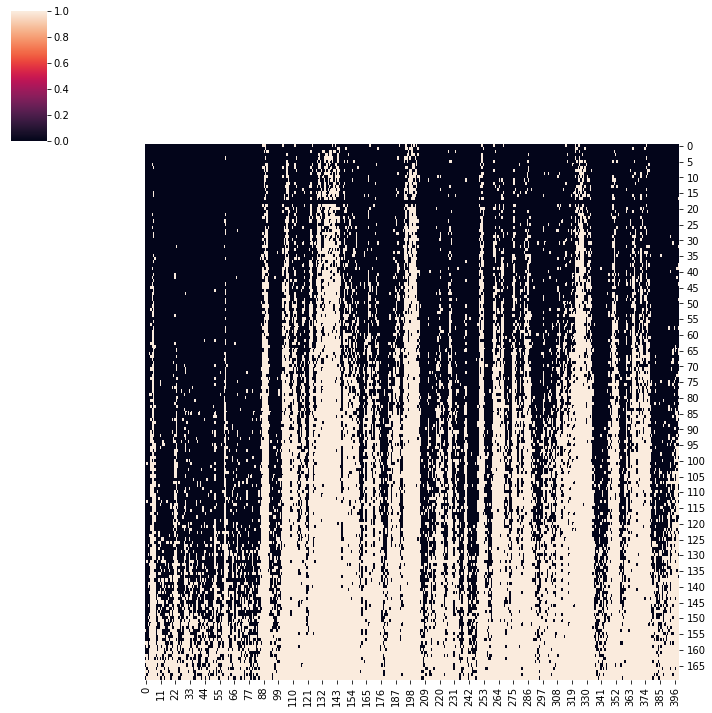

In [16]:

# Plot replicated state

guide_trace = poutine.trace(guide).get_trace(cn, data=reads)
trained_model = poutine.replay(model_S, trace=guide_trace)

inferred_model = infer_discrete(
    trained_model, temperature=0,
    first_available_dim=-3)
trace = poutine.trace(inferred_model).get_trace(cn, data=reads)

sns.clustermap(trace.nodes["rep"]["value"].numpy().astype(float).T[np.argsort(t), :],
               col_cluster=False, row_cluster=False)

trace.nodes["rep"]["value"].numpy()


In [17]:

map_estimates = guide(cn, data=reads)

print(map_estimates['a'].detach().numpy())
print(map_estimates['t'].detach().numpy().round(2))


[85.76177]
[0.47 0.43 0.54 0.47 0.55 0.45 0.52 0.46 0.54 0.55 0.53 0.54 0.49 0.55
 0.47 0.44 0.51 0.47 0.5  0.45 0.45 0.51 0.55 0.43 0.53 0.52 0.47 0.44
 0.45 0.45 0.49 0.51 0.54 0.53 0.5  0.47 0.44 0.45 0.54 0.46 0.54 0.5
 0.51 0.46 0.49 0.55 0.47 0.53 0.47 0.49 0.52 0.49 0.48 0.45 0.55 0.55
 0.47 0.46 0.55 0.45 0.52 0.52 0.47 0.48 0.45 0.5  0.46 0.45 0.46 0.44
 0.51 0.43 0.48 0.47 0.5  0.44 0.47 0.43 0.49 0.49 0.51 0.5  0.44 0.51
 0.52 0.53 0.5  0.5  0.45 0.47 0.55 0.5  0.52 0.52 0.46 0.47 0.49 0.47
 0.49 0.51 0.46 0.44 0.48 0.45 0.48 0.54 0.47 0.51 0.53 0.46 0.47 0.5
 0.51 0.51 0.45 0.5  0.51 0.51 0.5  0.51 0.46 0.48 0.46 0.54 0.5  0.5
 0.5  0.49 0.53 0.44 0.52 0.53 0.47 0.53 0.53 0.51 0.48 0.45 0.49 0.48
 0.45 0.51 0.51 0.51 0.55 0.46 0.46 0.49 0.49 0.52 0.46 0.54 0.44 0.52
 0.48 0.44 0.49 0.51 0.44 0.51 0.54 0.51 0.52 0.45 0.45 0.53 0.5  0.53
 0.43 0.15]


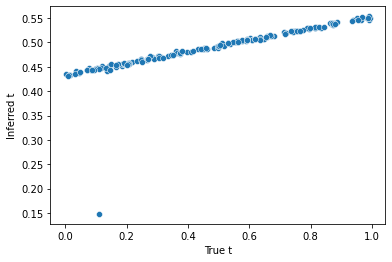

In [18]:

sns.scatterplot(
    x=t,
    y=map_estimates['t'].detach().numpy(),
)
plt.xlabel('True t')
plt.ylabel('Inferred t')
plt.show()

In [19]:
map_estimates

{'a': tensor([85.7618], grad_fn=<ExpandBackward0>),
 'rt': tensor([0.5577, 0.5507, 0.5493, 0.5357, 0.4974, 0.4698, 0.4597, 0.5063, 0.5507,
         0.5441, 0.5285, 0.5285, 0.5366, 0.5357, 0.5479, 0.5453, 0.5418, 0.5418,
         0.5407, 0.5396, 0.5407, 0.5245, 0.4988, 0.4890, 0.5214, 0.5418, 0.5557,
         0.5429, 0.5418, 0.5176, 0.5091, 0.5311, 0.5338, 0.5261, 0.5285, 0.5329,
         0.5466, 0.5493, 0.5302, 0.5302, 0.5523, 0.5386, 0.5386, 0.5338, 0.5302,
         0.5407, 0.5407, 0.5523, 0.5479, 0.5407, 0.5418, 0.5418, 0.5022, 0.5285,
         0.5396, 0.5418, 0.5429, 0.5429, 0.5357, 0.4869, 0.4705, 0.5154, 0.5338,
         0.5376, 0.5493, 0.5221, 0.5237, 0.5429, 0.5176, 0.5191, 0.5396, 0.5366,
         0.5418, 0.5329, 0.5441, 0.5329, 0.5320, 0.5329, 0.5479, 0.5479, 0.5237,
         0.5418, 0.5493, 0.5429, 0.5453, 0.5294, 0.5169, 0.4967, 0.4604, 0.4497,
         0.4416, 0.4436, 0.4798, 0.5154, 0.5329, 0.5357, 0.5285, 0.5329, 0.5311,
         0.5285, 0.5311, 0.5237, 0.5119, 0.4612, 0.

In [20]:

for k in pyro.get_param_store():
    print(k, pyro.get_param_store()[k])


AutoDelta.a tensor([85.7618], grad_fn=<AddBackward0>)
AutoDelta.rt Parameter containing:
tensor([0.5577, 0.5507, 0.5493, 0.5357, 0.4974, 0.4698, 0.4597, 0.5063, 0.5507,
        0.5441, 0.5285, 0.5285, 0.5366, 0.5357, 0.5479, 0.5453, 0.5418, 0.5418,
        0.5407, 0.5396, 0.5407, 0.5245, 0.4988, 0.4890, 0.5214, 0.5418, 0.5557,
        0.5429, 0.5418, 0.5176, 0.5091, 0.5311, 0.5338, 0.5261, 0.5285, 0.5329,
        0.5466, 0.5493, 0.5302, 0.5302, 0.5523, 0.5386, 0.5386, 0.5338, 0.5302,
        0.5407, 0.5407, 0.5523, 0.5479, 0.5407, 0.5418, 0.5418, 0.5022, 0.5285,
        0.5396, 0.5418, 0.5429, 0.5429, 0.5357, 0.4869, 0.4705, 0.5154, 0.5338,
        0.5376, 0.5493, 0.5221, 0.5237, 0.5429, 0.5176, 0.5191, 0.5396, 0.5366,
        0.5418, 0.5329, 0.5441, 0.5329, 0.5320, 0.5329, 0.5479, 0.5479, 0.5237,
        0.5418, 0.5493, 0.5429, 0.5453, 0.5294, 0.5169, 0.4967, 0.4604, 0.4497,
        0.4416, 0.4436, 0.4798, 0.5154, 0.5329, 0.5357, 0.5285, 0.5329, 0.5311,
        0.5285, 0.5311, 0.5237,

### Now try to infer with a model that treats all loci independently (agnostic to a bulk `rt` profile)

In [21]:
u_guess = torch.mean(reads) / (1.5 * torch.mean(cn))
u_guess

tensor(66.3220)

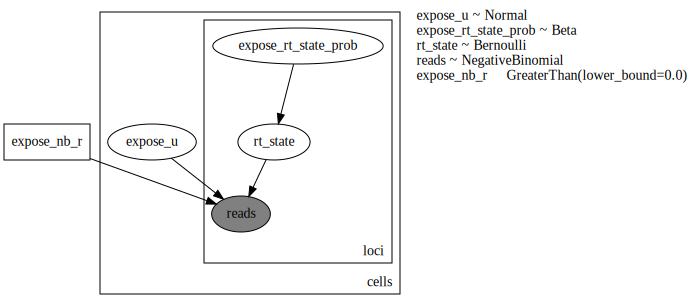

In [22]:
@config_enumerate
def model_S2(cn_profiles, read_profiles=None, u_guess=61.0):
    num_loci, num_cells = map(int, cn_profiles.shape)
    if read_profiles is not None:
        assert read_profiles.shape == cn_profiles.shape

    # scale each cell's read count so that it sums to 1 million reads and do some reshaping
    # epsilon = torch.finfo(torch.float64).eps
    
    alphas = torch.ones(num_loci, num_cells)
    betas = torch.ones(num_loci, num_cells)
    
    # draw true read count from Poisson distribution
    with pyro.plate("cells", num_cells):
        # per cell reads per copy scaling factor for each bin
        u = pyro.sample("expose_u", dist.Normal(torch.ones(num_cells)*u_guess, torch.tensor([u_guess/10.])))
        with pyro.plate("loci", num_loci):
            # draw each bin's replication probability from Beta
            prob_replicated = pyro.sample("expose_rt_state_prob", dist.Beta(alphas, betas))
            # draw replicated status from Bernoulli
            replicated = pyro.sample("rt_state", dist.Bernoulli(prob_replicated))
            # double the expected read count in bins that have been replicated
            rep_cn = cn_profiles * (1 + replicated)
            
            # negative binomial dispersion
            nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

            # expected reads per bin per cell
            expected_reads = (u * rep_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=read_profiles)
    
    return reads

pyro.render_model(model_S2, model_args=(cn, reads, u_guess), 
                  render_distributions=True, render_params=True)

In [23]:
optim_2 = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo_2 = TraceEnum_ELBO(max_plate_nesting=2)

guide_2 = AutoDelta(poutine.block(model_S2, expose_fn=lambda msg: msg["name"].startswith("expose_")))
svi_2 = SVI(model_S2, guide_2, optim_2, loss=elbo_2)

In [24]:
cn.dtype, reads.dtype

(torch.float32, torch.float32)

In [25]:
cn2 = cn.type(torch.float32)
reads2 = reads.type(torch.float32)
u_guess = u_guess.type(torch.float32)

In [26]:
print('Start Inference.')
losses = []
for i in range(5000):
    loss = svi_2.step(cn2, reads2, u_guess)

    # try a fancier convergence check.. not sure if it's working though
    if i >= 10:
        loss_diff = abs(max(losses[-10:-1]) - min(losses[-10:-1])) / abs(losses[-1])
        if loss_diff < 5e-5:
            print('ELBO converged at iteration ' + str(i))
            break

    losses.append(loss)
    print('.', end='')

map_estimates_2 = guide_2(cn2, reads2, u_guess)

Start Inference.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

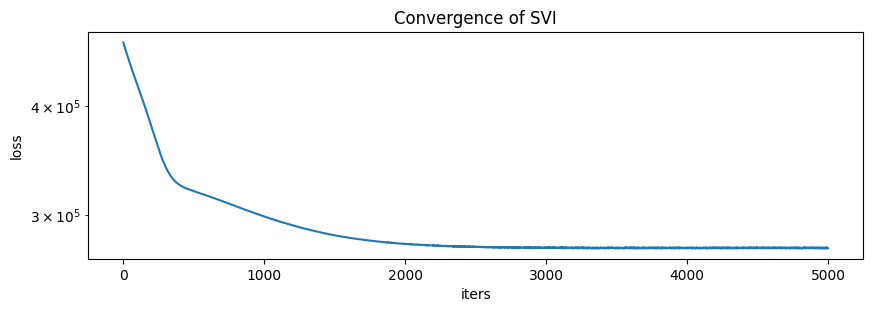

In [27]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI')
plt.show()

In [28]:
rt_state_probs = map_estimates_2['expose_rt_state_prob'].detach().numpy()

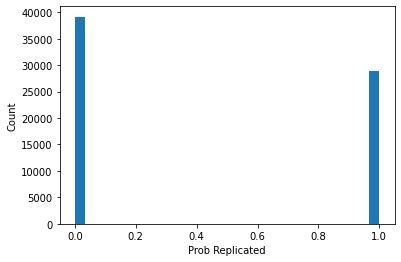

In [29]:
plt.hist(rt_state_probs.reshape(-1, 1), bins=30)
plt.xlabel('Prob Replicated')
plt.ylabel('Count')
plt.show()

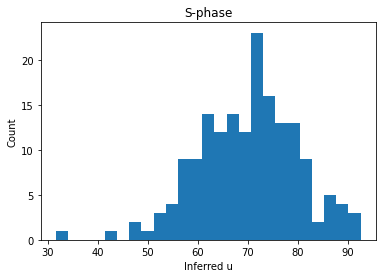

In [30]:
u_fit_s = map_estimates_2['expose_u'].detach().numpy()
plt.hist(u_fit_s, bins=25)
plt.xlabel('Inferred u')
plt.ylabel('Count')
plt.title('S-phase')
plt.show()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]], dtype=float32)

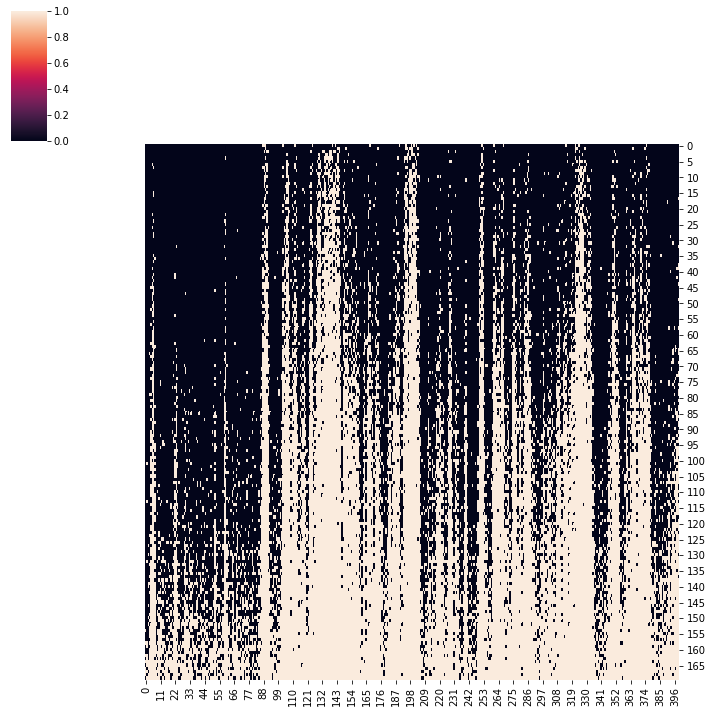

In [31]:
# Plot replicated state

guide_trace_2 = poutine.trace(guide_2).get_trace(cn, reads)
trained_model_2 = poutine.replay(model_S2, trace=guide_trace_2)

inferred_model_2 = infer_discrete(
    trained_model_2, temperature=0,
    first_available_dim=-3)
trace_2 = poutine.trace(inferred_model_2).get_trace(cn, reads)

sns.clustermap(trace_2.nodes["rt_state"]["value"].numpy().astype(float).T[np.argsort(t), :],
               col_cluster=False, row_cluster=False)

trace_2.nodes["rt_state"]["value"].numpy()


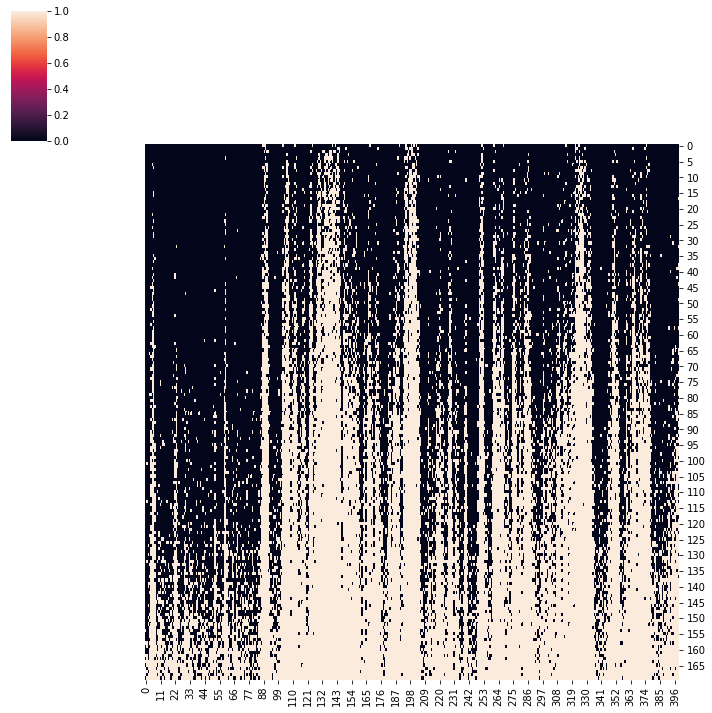

In [32]:
# plot the true heatmap of replication status
sns.clustermap(rep.numpy().astype(float).T[np.argsort(t), :],
               col_cluster=False, row_cluster=False)

In [33]:
maxprob_accuracy = 1.0 - (np.sum(abs(rep.numpy() - trace_2.nodes["rt_state"]["value"].numpy())) / (rep.shape[0] * rep.shape[1]))
maxprob_accuracy

0.9999705882352942

### Wrangle the true and inferred values into a dataframe

In [34]:
cn_s_out = []
for i in range(num_cells):
    temp_cn = rtdata.iloc[:num_loci]
    temp_cn['cell_id'] = 'cell_{}'.format(i)
    temp_cn['state'] = cn[:,i]
    temp_cn['reads'] = reads[:,i]
    temp_cn['true_rep'] = rep[:,i]
    temp_cn['true_u'] = u[i].numpy()
    temp_cn['true_t'] = t[i].numpy()
    temp_cn['true_nb_r'] = nb_r.detach().numpy()[0]
    temp_cn['true_a'] = a.numpy()[0]
    
    # results from model_S
    temp_cn['model1_rep'] = trace.nodes["rep"]["value"].numpy()[:,i]
    temp_cn['model1_t'] = trace.nodes["t"]["value"][i].detach().numpy()
    temp_cn['model1_u'] = trace.nodes["u"]["value"][i].detach().numpy()
    temp_cn['model1_nb_r'] = trace.nodes["nb_r"]["value"][0].detach().numpy()
    temp_cn['model1_a'] = trace.nodes["a"]["value"][0].detach().numpy()
    
    # results from model_S2
    temp_cn['model2_rep'] = trace_2.nodes["rt_state"]["value"].numpy()[:,i]
    temp_cn['model2_rep_prob'] = trace_2.nodes["expose_rt_state_prob"]["value"].detach().numpy()[:,i]
    temp_cn['model2_u'] = trace_2.nodes["expose_u"]["value"][i].detach().numpy()
    temp_cn['model2_nb_r'] = trace_2.nodes["expose_nb_r"]["value"][0].detach().numpy()
    
    cn_s_out.append(temp_cn)
cn_s_out = pd.concat(cn_s_out, ignore_index=True)

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithC

In [35]:
cn_s_out.head()

,chr,start,end,gc,mcf7rt,bin_size,norm_mcf7rt,cell_id,state,reads,...,true_a,model1_rep,model1_t,model1_u,model1_nb_r,model1_a,model2_rep,model2_rep_prob,model2_u,model2_nb_r
0,1,1000000,1500000,0.598330,81.441980,500000,1.000000,cell_0,2.0,140.0,...,10.0,0.0,0.47094,74.076057,2523.98877,85.761772,0.0,1.170297e-07,74.076073,10185.405273
1,1,1500000,2000000,0.539496,79.131013,500000,0.966776,cell_0,2.0,139.0,...,10.0,0.0,0.47094,74.076057,2523.98877,85.761772,0.0,1.168548e-07,74.076073,10185.405273
2,1,2000000,2500000,0.594508,78.557313,500000,0.958528,cell_0,2.0,152.0,...,10.0,0.0,0.47094,74.076057,2523.98877,85.761772,0.0,1.171487e-07,74.076073,10185.405273
3,1,3000000,3500000,0.584570,70.388076,500000,0.841080,cell_0,2.0,132.0,...,10.0,0.0,0.47094,74.076057,2523.98877,85.761772,0.0,1.169113e-07,74.076073,10185.405273
4,1,4000000,4500000,0.482572,48.663092,500000,0.528744,cell_0,2.0,133.0,...,10.0,0.0,0.47094,74.076057,2523.98877,85.761772,0.0,1.169248e-07,74.076073,10185.405273


In [36]:
for cell_id, chunk in cn_s_out.groupby('cell_id'):
    # add fraction of replicated bins per cell
    temp_rep0 = chunk.true_rep.values
    cn_s_out.loc[chunk.index, 'true_frac_rt'] = sum(temp_rep0) / temp_rep0.shape[0]
    temp_rep1 = chunk.model1_rep.values
    cn_s_out.loc[chunk.index, 'model1_frac_rt'] = sum(temp_rep1) / temp_rep1.shape[0]
    temp_rep2 = chunk.model2_rep.values
    cn_s_out.loc[chunk.index, 'model2_frac_rt'] = sum(temp_rep2) / temp_rep2.shape[0]
    
    # add per-cell replication state acccuracy
    accuracy1 = 1.0 - (sum(abs(chunk['true_rep'] - chunk['model1_rep'])) / chunk.shape[0])
    cn_s_out.loc[chunk.index, 'model1_rep_acc'] = accuracy1
    accuracy2 = 1.0 - (sum(abs(chunk['true_rep'] - chunk['model2_rep'])) / chunk.shape[0])
    cn_s_out.loc[chunk.index, 'model2_rep_acc'] = accuracy2
    
cn_s_out.head()

,chr,start,end,gc,mcf7rt,bin_size,norm_mcf7rt,cell_id,state,reads,...,model1_a,model2_rep,model2_rep_prob,model2_u,model2_nb_r,true_frac_rt,model1_frac_rt,model2_frac_rt,model1_rep_acc,model2_rep_acc
0,1,1000000,1500000,0.598330,81.441980,500000,1.000000,cell_0,2.0,140.0,...,85.761772,0.0,1.170297e-07,74.076073,10185.405273,0.25,0.25,0.25,1.0,1.0
1,1,1500000,2000000,0.539496,79.131013,500000,0.966776,cell_0,2.0,139.0,...,85.761772,0.0,1.168548e-07,74.076073,10185.405273,0.25,0.25,0.25,1.0,1.0
2,1,2000000,2500000,0.594508,78.557313,500000,0.958528,cell_0,2.0,152.0,...,85.761772,0.0,1.171487e-07,74.076073,10185.405273,0.25,0.25,0.25,1.0,1.0
3,1,3000000,3500000,0.584570,70.388076,500000,0.841080,cell_0,2.0,132.0,...,85.761772,0.0,1.169113e-07,74.076073,10185.405273,0.25,0.25,0.25,1.0,1.0
4,1,4000000,4500000,0.482572,48.663092,500000,0.528744,cell_0,2.0,133.0,...,85.761772,0.0,1.169248e-07,74.076073,10185.405273,0.25,0.25,0.25,1.0,1.0


In [37]:
cell_metrics = cn_s_out[['cell_id', 'true_a', 'true_nb_r', 'true_t', 'true_u', 'true_frac_rt', 'model1_rep_acc',
                         'model1_nb_r', 'model1_a', 'model1_t', 'model1_u', 'model1_frac_rt', 'model2_rep_acc',
                         'model2_nb_r', 'model2_u', 'model2_frac_rt']].drop_duplicates()
cell_metrics.shape

(170, 16)

In [38]:
cell_metrics.head()

,cell_id,true_a,true_nb_r,true_t,true_u,true_frac_rt,model1_rep_acc,model1_nb_r,model1_a,model1_t,model1_u,model1_frac_rt,model2_rep_acc,model2_nb_r,model2_u,model2_frac_rt
0,cell_0,10.0,10000.000977,0.311923,74.189346,0.2500,1.0,2523.98877,85.761772,0.470940,74.076057,0.2500,1.0,10185.405273,74.076073,0.2500
400,cell_1,10.0,10000.000977,0.014576,59.146317,0.0475,1.0,2523.98877,85.761772,0.432426,59.029274,0.0475,1.0,10185.405273,59.031044,0.0475
800,cell_2,10.0,10000.000977,0.865297,75.188286,0.8200,1.0,2523.98877,85.761772,0.538378,74.979561,0.8200,1.0,10185.405273,74.968269,0.8200
1200,cell_3,10.0,10000.000977,0.301940,73.645782,0.2650,1.0,2523.98877,85.761772,0.472977,73.736031,0.2650,1.0,10185.405273,73.728027,0.2650
1600,cell_4,10.0,10000.000977,0.991751,77.735062,0.8775,1.0,2523.98877,85.761772,0.546023,77.895447,0.8775,1.0,10185.405273,77.887428,0.8775


In [39]:
loci_metrics = rtdata.iloc[:num_loci]
loci_metrics['true_bulk_rt'] = np.mean(rep.numpy(), axis=1)
loci_metrics['model1_bulk_rt'] = np.mean(trace.nodes["rep"]["value"].numpy(), axis=1)
loci_metrics['model2_bulk_rt'] = np.mean(trace_2.nodes["rt_state"]["value"].numpy(), axis=1)
loci_metrics.head()

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-package

,chr,start,end,gc,mcf7rt,bin_size,norm_mcf7rt,true_bulk_rt,model1_bulk_rt,model2_bulk_rt
0,1,1000000,1500000,0.598330,81.441980,500000,1.000000,0.041176,0.041176,0.041176
1,1,1500000,2000000,0.539496,79.131013,500000,0.966776,0.064706,0.064706,0.064706
2,1,2000000,2500000,0.594508,78.557313,500000,0.958528,0.070588,0.070588,0.070588
3,1,3000000,3500000,0.584570,70.388076,500000,0.841080,0.141176,0.141176,0.141176
4,1,4000000,4500000,0.482572,48.663092,500000,0.528744,0.441176,0.441176,0.441176


### Evaluate performance of model1 (same as generative)

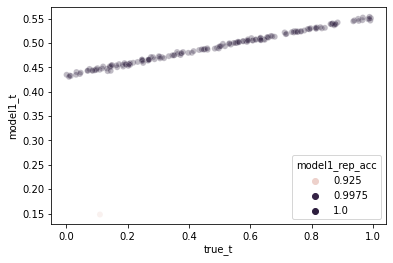

In [40]:
sns.scatterplot(data=cell_metrics, x='true_t', y='model1_t', hue='model1_rep_acc', alpha=0.3)
plt.show()

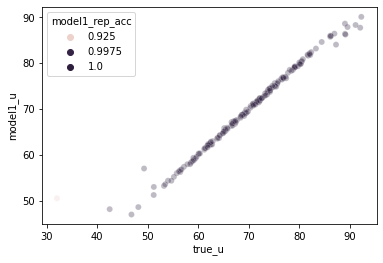

In [41]:
sns.scatterplot(data=cell_metrics, x='true_u', y='model1_u', hue='model1_rep_acc', alpha=0.3)
plt.show()

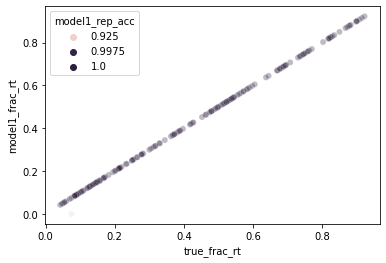

In [42]:
sns.scatterplot(data=cell_metrics, x='true_frac_rt', y='model1_frac_rt', hue='model1_rep_acc', alpha=0.3)
plt.show()

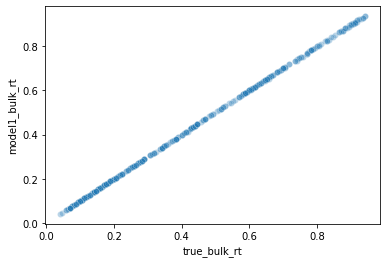

In [43]:
sns.scatterplot(data=loci_metrics, x='true_bulk_rt', y='model1_bulk_rt', alpha=0.3)
plt.show()

### Evaluate performance of model2 (each bin is independent)

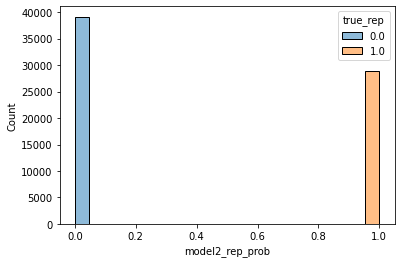

In [44]:
sns.histplot(data=cn_s_out, x='model2_rep_prob', hue='true_rep')
plt.show()

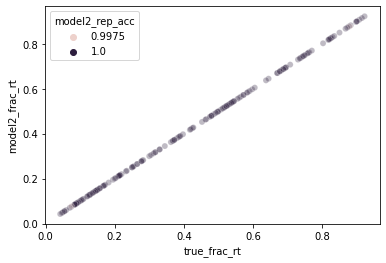

In [45]:
sns.scatterplot(data=cell_metrics, x='true_frac_rt', y='model2_frac_rt', hue='model2_rep_acc', alpha=0.3)
plt.show()

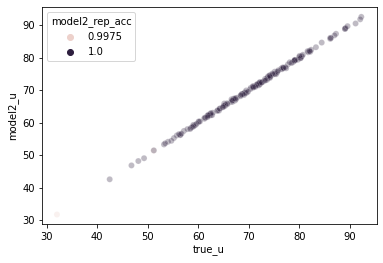

In [46]:
sns.scatterplot(data=cell_metrics, x='true_u', y='model2_u', hue='model2_rep_acc', alpha=0.3)
plt.show()